In [81]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)


from darts.models import (
    Prophet,
    RNNModel,
    ARIMA,
    AutoARIMA,
    LinearRegressionModel,
    ExponentialSmoothing,
)
from darts.metrics import mape, mse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


In [82]:
#import the dataset and create a dataframe
df = pd.read_csv("yahoo_stock.csv", delimiter=",")

#Create timeseries object of all columns in the dataframe
openSeries = TimeSeries.from_dataframe(df, "Date", "Open")
closeSeries = TimeSeries.from_dataframe(df, "Date", "Close")
highSeries = TimeSeries.from_dataframe(df, "Date", "High")
lowSeries = TimeSeries.from_dataframe(df, "Date", "Low")
adjSeries = TimeSeries.from_dataframe(df, "Date", "Adj Close")
volumeSeries = TimeSeries.from_dataframe(df, "Date", "Volume")
multiSeries = TimeSeries.from_dataframe(df, "Date", ["Open", "Close", "High", "Low", "Adj Close"])

#Split the series into training and validation sets
openTrain, openVal = openSeries[:-365], openSeries[-365:]
closeTrain, closeVal = closeSeries[:-365], closeSeries[-365:]
highTrain, highVal = highSeries[:-365], highSeries[-365:]
lowTrain, lowVal = lowSeries[:-365], lowSeries[-365:]
adjTrain, adjVal = adjSeries[:-365], adjSeries[-365:]
multiTrain, multiVal = multiSeries[:-365], multiSeries[-365:]

#Create scalers for normalization
closeNorm, openNorm, lowNorm, highNorm, adjNorm, multiNorm = Scaler(), Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
closeNormData, openNormData, lowNormData, highNormData, adjNormData, multiNormData = closeNorm.fit_transform(closeSeries), openNorm.fit_transform(openSeries), lowNorm.fit_transform(lowSeries), highNorm.fit_transform(highSeries), adjNorm.fit_transform(adjSeries), multiNorm.fit_transform(multiSeries)

#Split normalized data
closeTrainNorm, closeValNorm = closeNormData[:-365], closeNormData[-365:]
openTrainNorm, openValNorm = openNormData[:-365], openNormData[-365:]
highTrainNorm, highValNorm = highNormData[:-365], highNormData[-365:]
lowTrainNorm, lowValNorm = lowNormData[:-365], lowNormData[-365:]
adjTrainNorm, adjValNorm = adjNormData[:-365], adjNormData[-365:]
multiTrainNorm, multiValNorm = multiNormData[:-365], multiNormData[-365:]

#Get info 
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [83]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


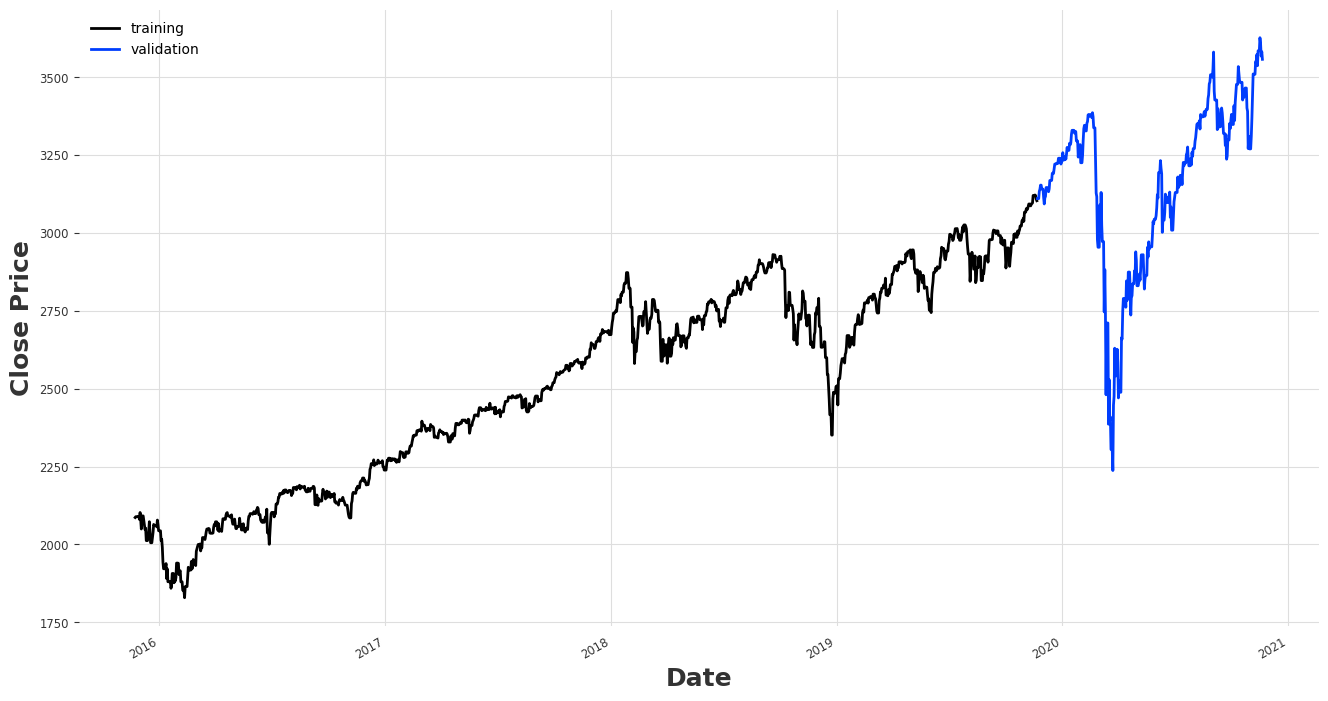

In [84]:
#Plot the dataset
plt.figure(figsize=(16,8))
closeTrain.plot(label="training")
closeVal.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [85]:
# Define the range of hyperparameters to search over
ps = range(0, 3)
ds = range(0, 2)
qs = range(0, 3)

# Create a list of all possible combinations of hyperparameters
params = list(itertools.product(ps, ds, qs))

# Initialize variables to store the best hyperparameters and best MAPE
best_params = None
best_mape = float('inf')
best_mse = float('inf')

# Loop over all hyperparameter combinations
for p, d, q in params:
    # Train an ARIMA model with the current hyperparameters
    model = ARIMA(p=p, d=d, q=q)
    model.fit(closeTrain)
    
    # Make predictions on the validation set
    preds = model.predict(n=len(closeVal))
    
    # Calculate the mean absolute percentage error (MAPE) of the predictions
    current_mape = mape(closeVal, preds)
    
    # Update the best hyperparameters and best MAPE if the current MAPE is better
    if current_mape < best_mape:
        best_mape = current_mape
        best_params = (p, d, q)
    

# Print the best hyperparameters and best MAPE
print(f'Best hyperparameters: {best_params}')
print(f'Best MAPE: {best_mape}')

c:\Anaconda\envs\DSS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Anaconda\envs\DSS\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best hyperparameters: (1, 1, 2)
Best MAPE: 7.4315638877384345


In [86]:
#instantiate models 
model1 = Prophet()
model2 = ExponentialSmoothing()
model3 = ARIMA(1, 1, 2)
model4 = AutoARIMA()
model5 = LinearRegressionModel(lags=365)


models = {
    "Prophet": model1,
    "Exponential": model2,
    "ARIMA": model3,
    "AutoARIMA": model4,
    "LinearRegressionModel": model5
}

Prophet


16:07:58 - cmdstanpy - INFO - Chain [1] start processing
16:07:59 - cmdstanpy - INFO - Chain [1] done processing


Exponential
ARIMA
AutoARIMA


ValueError: `num_samples > 1` is only supported for probabilistic models.
ValueError: `num_samples > 1` is only supported for probabilistic models.


LinearRegressionModel


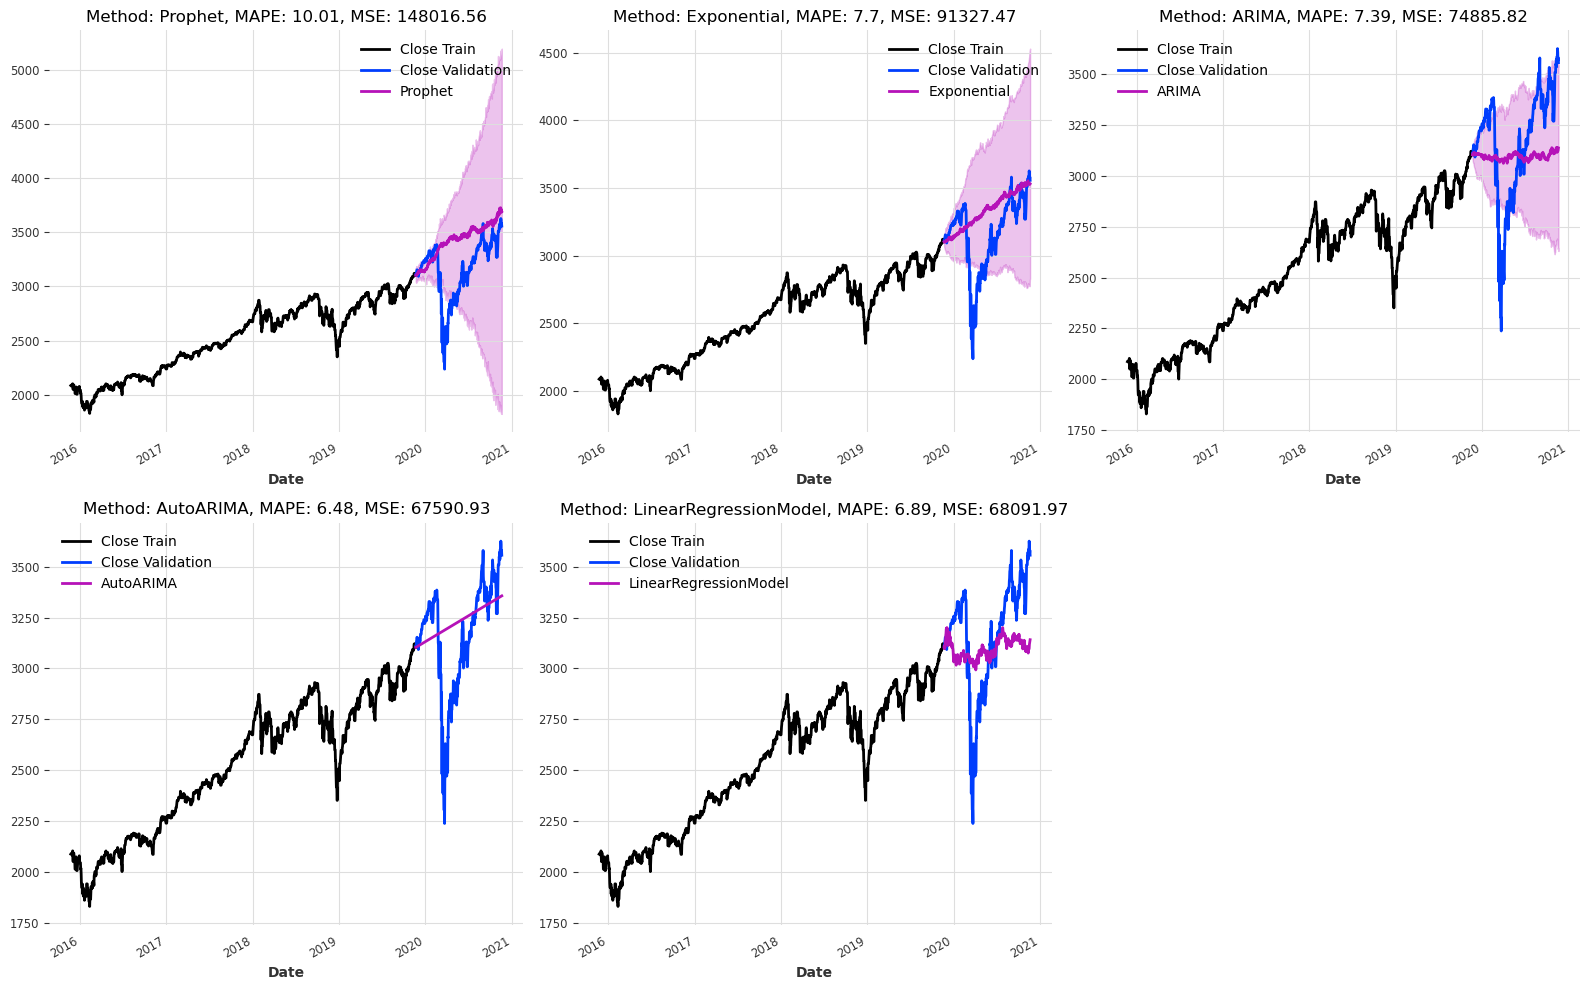

In [87]:
#Run the models and plot the results
fig = plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items()):
    print(name)
    model.fit(closeTrain)
    try:
        predictions = model.predict(n=len(closeVal), num_samples=100)
    except:
        predictions = model.predict(n=len(closeVal))
    mape_score = round(mape(closeVal, predictions), 2)
    mse_score = round(mse(closeVal, predictions), 2)

    fig.add_subplot(2, 3, i+1)
    closeTrain.plot(label="Close Train"); closeVal.plot(label="Close Validation"); predictions.plot(label=name)
    plt.title(f'Method: {name}, MAPE: {mape_score}, MSE: {mse_score}'); plt.legend()
fig.tight_layout()
plt.show()

In [88]:
# Using LSTM machine learning algorithm to forecast

modelLSTM = RNNModel(
    model = 'LSTM',
    input_chunk_length=120,
    output_chunk_length=10,
    n_epochs=100,
    random_state=0
)


#Normalized data LSTM prediction
modelLSTM.fit(series=multiTrainNorm)

#Regular data LSTM prediction
#modelLSTM.fit(series=closeSeries)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.2 K 
4 | V             | Linear           | 130   
---------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 45/45 [00:01<00:00, 32.30it/s, train_loss=8.42e-5] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 45/45 [00:01<00:00, 32.23it/s, train_loss=8.42e-5]


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=24, input_chunk_length=120, output_chunk_length=10, n_epochs=100, random_state=0)

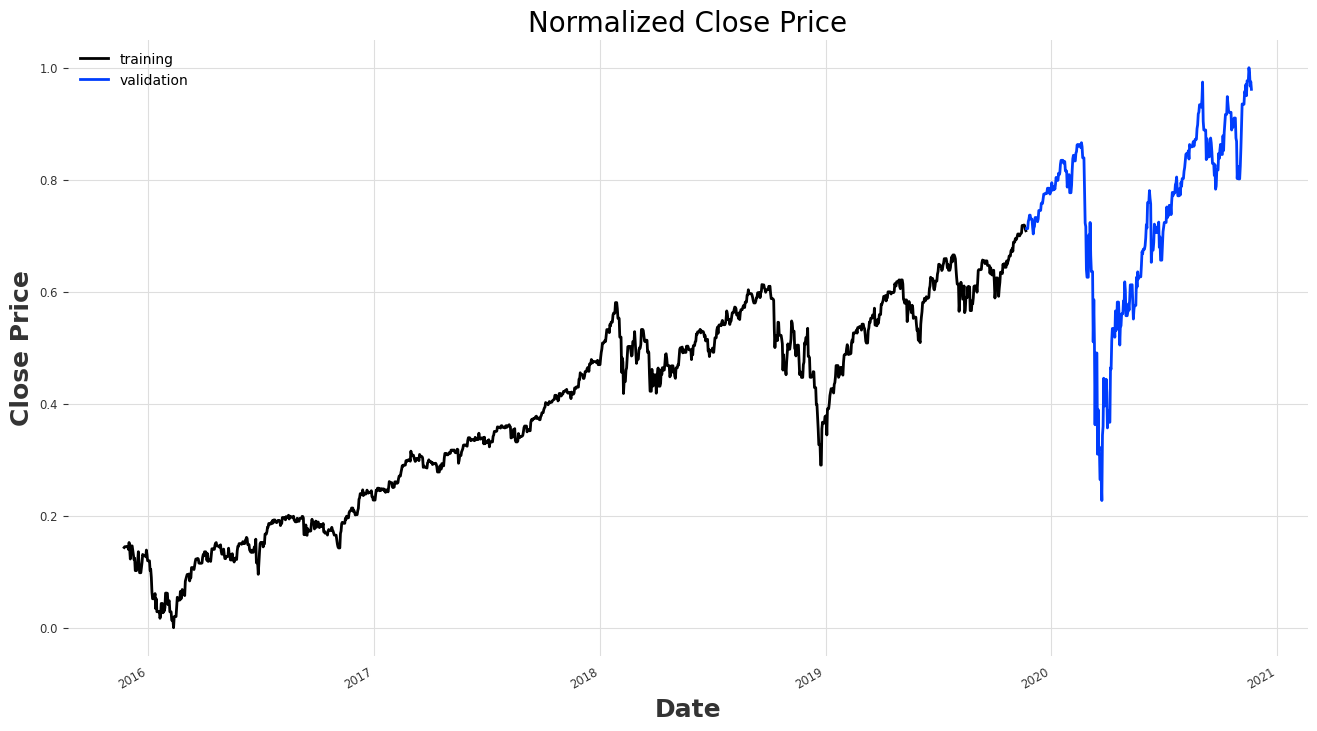

In [89]:
plt.figure(figsize=(16,8))
closeTrainNorm.plot(label="training")
closeValNorm.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.title('Normalized Close Price', fontsize=20)
plt.legend()
plt.show()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


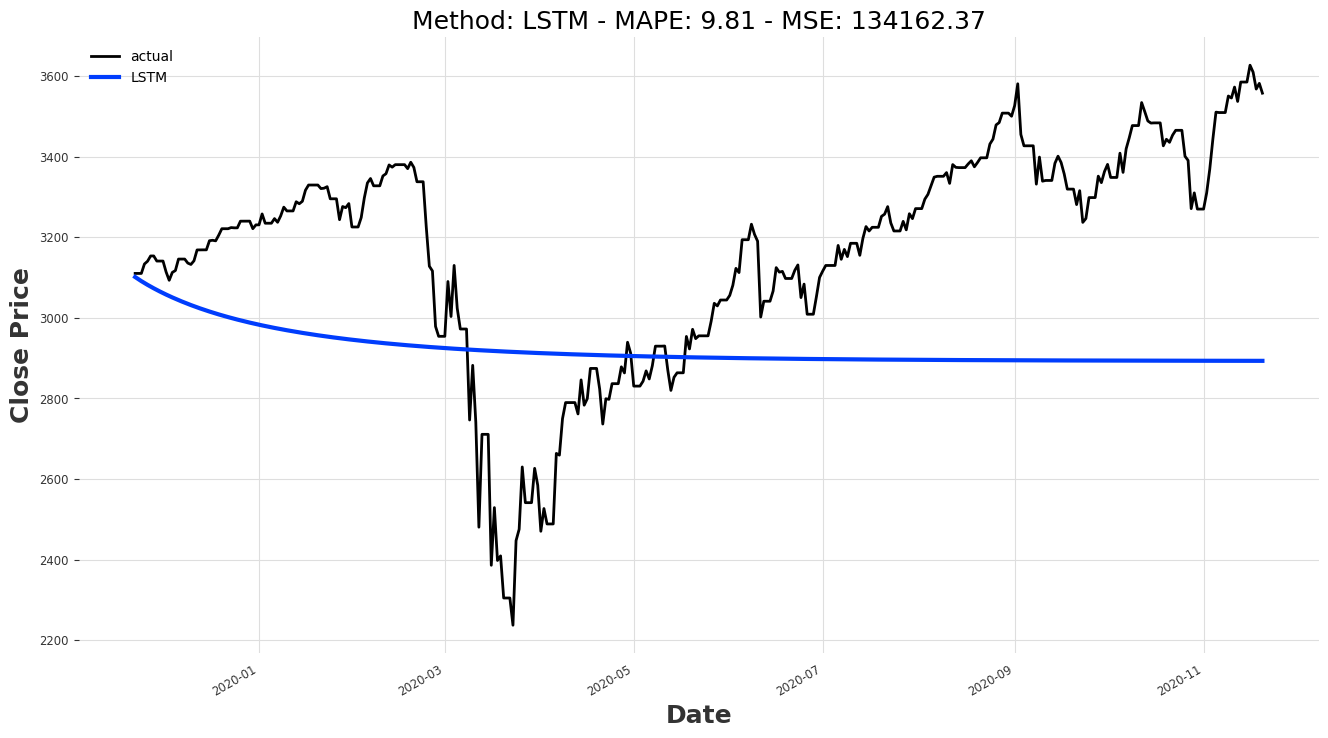

In [90]:
predictionLSTMNorm = modelLSTM.predict(n=len(closeValNorm))
predictionLSTMNorm = multiNorm.inverse_transform(predictionLSTMNorm)


mape_score = round(mape(closeVal, predictionLSTMNorm["Close"]), 2)
mse_score = round(mse(closeVal, predictionLSTMNorm["Close"]), 2)

plt.figure(figsize=(16,8))
closeVal.plot(label='actual')
predictionLSTMNorm["Close"].plot(label='LSTM', lw=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.title(f'Method: LSTM - MAPE: {mape_score} - MSE: {mse_score}', fontsize=18)
plt.legend()
plt.show()